In [7]:
# creating neural network from scratch
from sklearn.datasets import fetch_openml
X,y=fetch_openml('mnist_784',version=1,return_X_y=True)

In [8]:
X=X.values
y=y.astype(int).values
print(X.shape)
print(y.shape)
X=((X/255)-0.5)*2 #normalizing the data

(70000, 784)
(70000,)


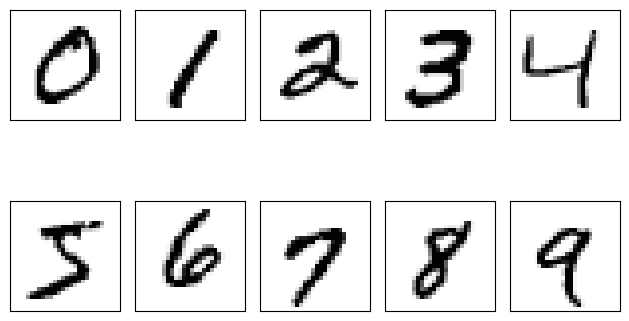

In [10]:
# visualize 0-9 digits
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,
sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
# split the data into training, testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=50000, random_state=123, stratify=y_train)

In [12]:
import numpy as np


##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h

In [13]:
# initialize neural network The model accepts MNIST images reshaped into 784-dimensional vectors (in the format of X_train, 
# X_valid, or X_test, which we defined previously) for the 10 integer classes (digits 0-9). The hidden 
# layer consists of 50 nodes.
model = NeuralNetMLP(num_features=28*28, 
                     num_hidden=50, 
                     num_classes=10)

In [15]:
# training the model, we will this in mini batches

import numpy as np 
num_epochs = 50 
minibatch_size = 100
def minibatch_generator(X, y, batch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0,indices.shape[0]-minibatch_size+1, minibatch_size):
    index_slice = indices[start_idx:start_idx+minibatch_size]
    yield X[index_slice], y[index_slice]


In [21]:
def mse_loss(targets,probas,num_labels=10):
    onehot_targets = int_to_onehot(targets,num_labels=num_labels)
    return np.mean((onehot_targets-probas)**2,axis=1)
def accuracy(targets, predicted_labels):
    return np.mean(targets==predicted_labels)

In [26]:
_,probas = model.forward(X_valid)
mse= mse_loss(y_valid,probas)
print(f'Validation MSE:',np.mean(mse))
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Validation accuracy: {acc:.2f}')


Validation MSE: 0.2709610406742955
Validation accuracy: 0.09


In [30]:
def compute_mse_and_acc(nnet, X, y, num_labels=10,
    minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
      _, probas = nnet.forward(features)
      predicted_labels = np.argmax(probas, axis=1)
      onehot_targets = int_to_onehot(
      targets, num_labels=num_labels)
      loss = np.mean((onehot_targets - probas)**2)
      correct_pred += (predicted_labels == targets).sum()
      num_examples += targets.shape[0]
      mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [31]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Validation MSE: {mse:.1f}, Validation Acc: {acc:.2f}')


Validation MSE: 0.3, Validation Acc: 0.09


In [35]:
# implemen the training loop
def train(model,X_train,y_train,X_valid,y_valid,num_epochs=50,learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range (num_epochs):
        minibatch_gen= minibatch_generator(X_train,y_train,minibatch_size)
        for X_train_mini,y_train_mini in minibatch_gen:
            # forward pass-- compute the outputs
            a_h,a_out = model.forward(X_train_mini)
            # compute the loss-- gradient descent
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            # update the weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        # Epochs logging
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc,valid_acc = train_acc*100,valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Validation Acc: {valid_acc:.2f}%')
    return epoch_loss,epoch_train_acc,epoch_valid_acc

In [36]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,num_epochs=50, learning_rate=0.1)

Epoch: 1/50 | Train Acc: 33.80% | Validation Acc: 33.72%
Epoch: 2/50 | Train Acc: 46.33% | Validation Acc: 46.77%
Epoch: 3/50 | Train Acc: 62.05% | Validation Acc: 62.25%
Epoch: 4/50 | Train Acc: 69.40% | Validation Acc: 69.84%
Epoch: 5/50 | Train Acc: 75.25% | Validation Acc: 74.93%
Epoch: 6/50 | Train Acc: 78.58% | Validation Acc: 78.15%
Epoch: 7/50 | Train Acc: 81.23% | Validation Acc: 80.84%
Epoch: 8/50 | Train Acc: 82.99% | Validation Acc: 82.52%
Epoch: 9/50 | Train Acc: 84.23% | Validation Acc: 83.76%
Epoch: 10/50 | Train Acc: 85.18% | Validation Acc: 84.47%
Epoch: 11/50 | Train Acc: 86.05% | Validation Acc: 85.54%
Epoch: 12/50 | Train Acc: 86.90% | Validation Acc: 86.25%
Epoch: 13/50 | Train Acc: 87.00% | Validation Acc: 86.24%
Epoch: 14/50 | Train Acc: 87.79% | Validation Acc: 86.95%
Epoch: 15/50 | Train Acc: 88.30% | Validation Acc: 87.48%
Epoch: 16/50 | Train Acc: 88.53% | Validation Acc: 87.75%
Epoch: 17/50 | Train Acc: 88.88% | Validation Acc: 88.08%
Epoch: 18/50 | Train Ac

In [41]:
print("model.weight_h:",model.weight_h )
print("model.bias_h:",model.bias_h )
print("model.weight_out:",model.weight_out )
print("model.bias_out:",model.bias_out )

model.weight_h: [[-0.10952878  0.09876882  0.02733213 ... -0.20517536 -0.14088911
   0.10480379]
 [-0.05057237 -0.07738847 -0.05367562 ...  0.02872483 -0.06138355
   0.04095036]
 [-0.02418152 -0.16461015  0.01523666 ...  0.04630951  0.03582378
  -0.00117719]
 ...
 [-0.14743767  0.06355685 -0.04922569 ... -0.11641117 -0.117181
   0.20434975]
 [ 0.14054106 -0.0694644   0.06420117 ... -0.11876248 -0.22548478
  -0.06257009]
 [ 0.05230371 -0.03604399 -0.02709539 ... -0.03153416 -0.15202739
   0.04913558]]
model.bias_h: [ 0.00096572 -0.0155827   0.00156049  0.00681928  0.00996457  0.00880473
  0.00874617 -0.00875174  0.01210421  0.00317245 -0.0008186   0.00201298
  0.00992991  0.00064259  0.01702845  0.01133489  0.00723213  0.00678052
  0.00706405 -0.01160357 -0.00067367  0.0010537   0.01112312  0.00410395
 -0.00762945 -0.01709597  0.00492151  0.00357296  0.00500975 -0.00890451
  0.01195326 -0.00296896 -0.00055028  0.00338949 -0.00228705  0.0019077
  0.01487937  0.00076008  0.00613029  0.009

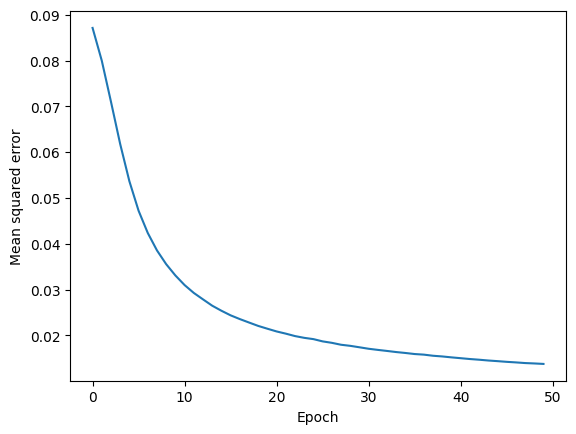

In [37]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

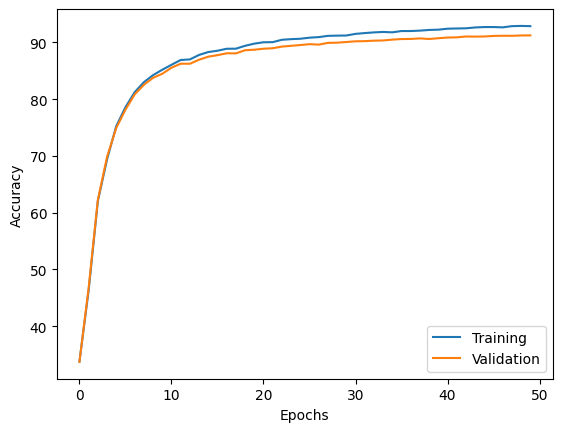

In [38]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [39]:
# test dataset: 
test_mse,test_acc=compute_mse_and_acc(model,X_test,y_test)
print(f'Test MSE: {test_mse:.2f}, Test Acc: {test_acc:.2f}')

Test MSE: 0.02, Test Acc: 0.91
